This notebook is used to compare different clustering algorithms on the 2d PCA version of images of the first page of documents.

In [86]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn. mixture import BayesianGaussianMixture
from annoy import AnnoyIndex
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
pca_2d_df = pd.read_json('pca_2d_df.json')
NUM_CLUSTERS = 4
pca_2d_df

,pca_weights
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-11.png,"[-0.17019432780000002, 0.2974085808]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-16.png,"[-0.189047128, 0.4553113878]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-18.png,"[-0.30082541700000004, -0.405326277]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-6.png,"[-0.5911592841000001, -0.1095318869]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC10-10.png,"[-0.4859670997, -0.3088041246]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC95-5.png,"[-0.4500951469, -0.3761140108]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC97-12.png,"[-0.45629838110000004, -0.34122911100000003]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC97-15.png,"[-0.48083657030000004, -0.3435045779]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC99-2.png,"[-0.4736335278, -0.4850648642]"


### K-Means Clustering

In [88]:
%matplotlib inline

from ipywidgets import interact

def k(n=2):
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=kmeans.labels_)
    plt.show()

interact(k, n=(2, 10))

interactive(children=(IntSlider(value=2, description='n', max=10, min=2), Output()), _dom_classes=('widget-int…

<function __main__.k(n=2)>

In [89]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['kmeans_cluster'] = kmeans.labels_

Text(0.5, 1.0, '2D representation of images clustered by KMeans')

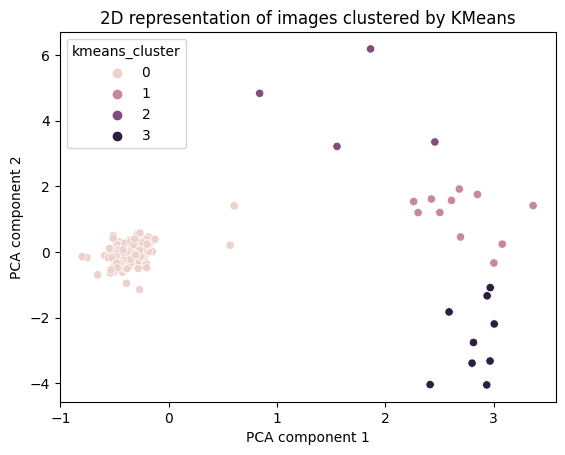

In [90]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['kmeans_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

### DBSCAN Clustering

In [91]:
%matplotlib inline

from ipywidgets import interact

def g(eps=0.5):
    DBSCAN_clustering = DBSCAN(eps=eps, min_samples=2).fit(pca_2d_df['pca_weights'].to_list())
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=DBSCAN_clustering.labels_)
    plt.show()

interact(g, eps=(0.5, 3))

interactive(children=(FloatSlider(value=0.5, description='eps', max=3.0, min=0.5), Output()), _dom_classes=('w…

<function __main__.g(eps=0.5)>

In [92]:
# eps = max. dist ton still be considered neighbour
# min_samples = min. number of neighbours to be considered a core point
DBSCAN_clustering = DBSCAN(eps=0.5, min_samples=2).fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['DBSCAN_cluster'] = DBSCAN_clustering.labels_

Text(0.5, 1.0, '2D representation of images clustered by DBSCAN')

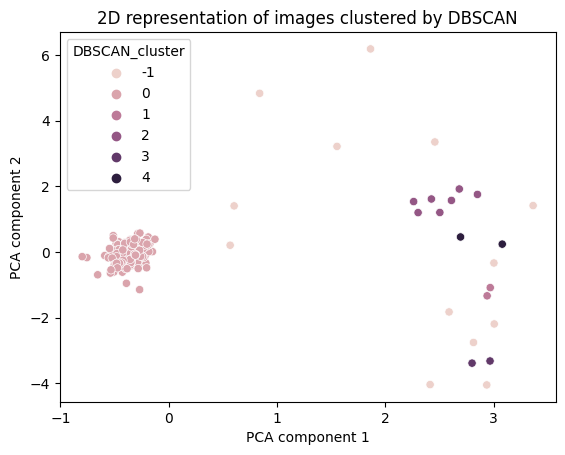

In [93]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['DBSCAN_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by DBSCAN')

### HDBSCAN*

In [94]:
%matplotlib inline

from ipywidgets import interact

def h(minimum_cluster_size=5, min_samples=1):
    hdbscan_clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=minimum_cluster_size, min_samples=min_samples, p=None)
    hdbscan_clusterer.fit(pca_2d_df['pca_weights'].to_list())
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=hdbscan_clusterer.labels_)
    plt.show()

# minimum_cluster_size = min. number of points in a cluster
# min_samples = min. number of neighbours to be considered a core point
interact(h, minimum_cluster_size=(1, 7), min_samples=(1, 7))

interactive(children=(IntSlider(value=5, description='minimum_cluster_size', max=7, min=1), IntSlider(value=1,…

<function __main__.h(minimum_cluster_size=5, min_samples=1)>

In [95]:
hdbscan_clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
hdbscan_clusterer.fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['hdbscan_cluster'] = hdbscan_clusterer.labels_

Text(0.5, 1.0, '2D representation of images clustered by HDBSCAN')

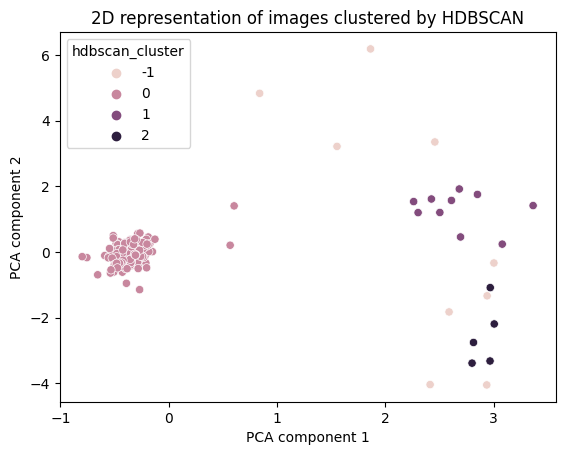

In [96]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['hdbscan_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by HDBSCAN')

### OPTICS

In [97]:
%matplotlib inline

from ipywidgets import interact

def i(eps=1, min_samples=2, min_cluster_size=2):
    optics_clustering = OPTICS(min_samples=min_samples,eps=eps, min_cluster_size=min_cluster_size).fit(pca_2d_df['pca_weights'].to_list())
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=optics_clustering.labels_)
    plt.show()

# eps = max. dist to still be considered neighbour
# min_samples = min. number of neighbours to be considered a core point
# min_cluster_size = min. number of points in a cluster
interact(i, eps=(1, 7), min_samples=(2, 7), min_cluster_size=(2, 7))

interactive(children=(IntSlider(value=1, description='eps', max=7, min=1), IntSlider(value=2, description='min…

<function __main__.i(eps=1, min_samples=2, min_cluster_size=2)>

In [98]:
optics_clustering = OPTICS(min_samples=2).fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['optics_cluster'] = optics_clustering.labels_

Text(0.5, 1.0, '2D representation of images clustered by OPTICS')

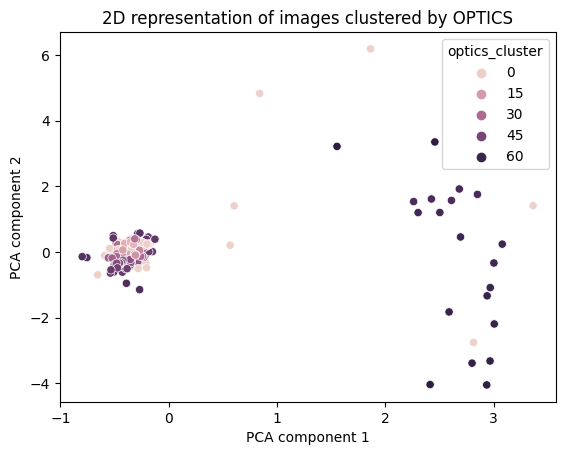

In [99]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['optics_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by OPTICS')

#### BayesianGaussianMixture

In [100]:
%matplotlib inline

from ipywidgets import interact

def i(n_components=2):
    bgm = BayesianGaussianMixture(n_components=n_components, random_state=42)
    bgm_cluster = bgm.fit_predict(pca_2d_df['pca_weights'].to_list())  
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=bgm_cluster)
    plt.show()

# n_components >= number of mixture components
interact(i, n_components=(2, 10))

interactive(children=(IntSlider(value=2, description='n_components', max=10, min=2), Output()), _dom_classes=(…

<function __main__.i(n_components=2)>

In [101]:
bgm = BayesianGaussianMixture(n_components=2, random_state=42)
pca_2d_df['bgm_cluster'] = bgm.fit_predict(pca_2d_df['pca_weights'].to_list())


Text(0.5, 1.0, '2D representation of images clustered by BayesianGaussianMixture')

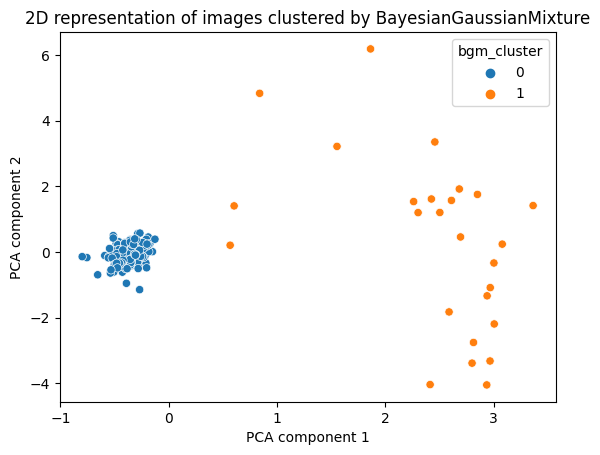

In [102]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['bgm_cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by BayesianGaussianMixture')

#### ANNOY
for more information see: https://www.slideshare.net/erikbern/approximate-nearest-neighbor-methods-and-vector-models-nyc-ml-meetup
ANNOY seems to only return estimation of nearest n neighbours and not the actual clusters.
Moreover, there is little information available online.

['/Users/klara/Documents/Uni/bachelorarbeit/images/SAC1-18.png', '/Users/klara/Documents/Uni/bachelorarbeit/images/SAC38-18.png', '/Users/klara/Documents/Uni/bachelorarbeit/images/SAC134-5.png']


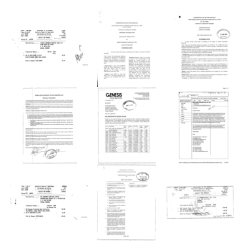

In [103]:
from doc_images.pdf_matrix import create_image_matrix

f = 2
t = AnnoyIndex(f, 'euclidean')
for i in range(len(pca_2d_df['pca_weights'])):
    v = pca_2d_df['pca_weights'].to_list()[i]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')
u = AnnoyIndex(f, 'euclidean')
u.load('test.ann') # super fast, will just mmap the file
# print three nearest neighbors of item with id 2
nearest_neighbours = [pca_2d_df.index.to_list()[i] for i in u.get_nns_by_item(2, 10)] # will find the 1000 nearest neighbors
print(nearest_neighbours[:3]) # will find the 1000 nearest neighbors
create_image_matrix(nearest_neighbours, 3)

### Compare Clustering Algorithms

In [104]:
# save different clusterings to json
pca_2d_df.to_json('pca_2d_df_clusters.json')

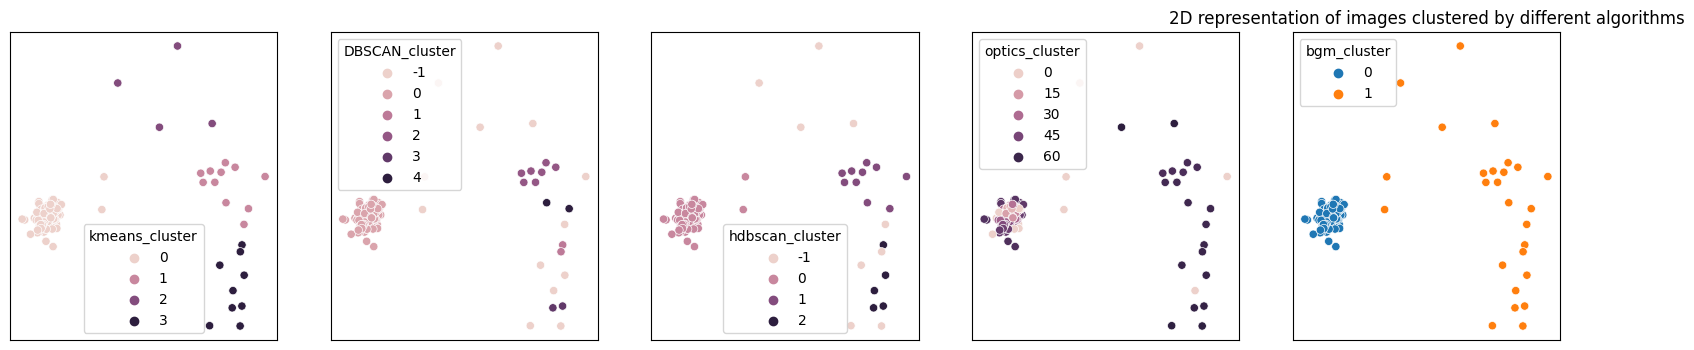

In [105]:
algos = list(pca_2d_df.keys())[1:]
num_algos = len(algos)
plt.figure(figsize=(20, 4))

for i in range(1, num_algos + 1):
    # Display original
    ax = plt.subplot(1, num_algos, i)
    sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df[algos[i - 1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.title('2D representation of images clustered by different algorithms', loc='center')
plt.show()

# compare in terms of example doc per cluster and algo

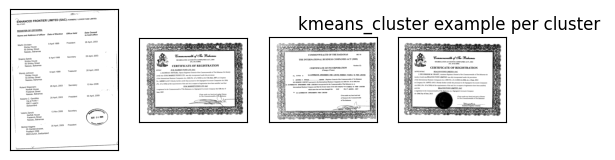

[ WARN:0@30308.872] global loadsave.cpp:248 findDecoder imread_(' '): can't open/read file: check file path/integrity


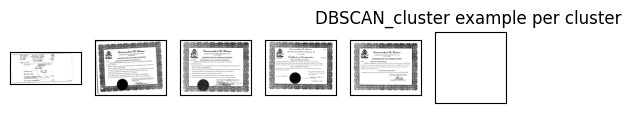

[ WARN:0@30308.964] global loadsave.cpp:248 findDecoder imread_(' '): can't open/read file: check file path/integrity


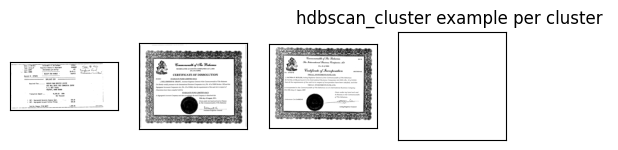

[ WARN:0@30309.800] global loadsave.cpp:248 findDecoder imread_(' '): can't open/read file: check file path/integrity


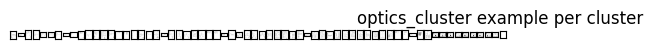

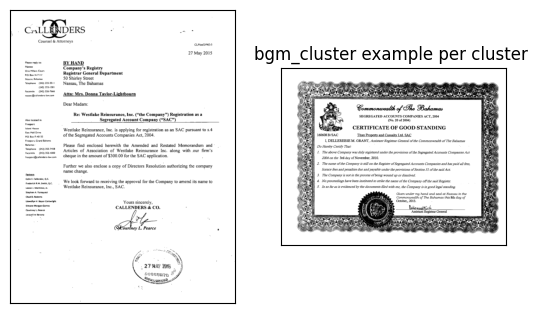

In [106]:
import cv2

d2_example_images = {}
for algo in algos:
    # display sample document per class
    d2_example_images[algo] = []
    for i in range(1, len(set(pca_2d_df[algo])) + 1):
        try:
            img_path = pca_2d_df[pca_2d_df[algo] == i - 1].sample(1).index.values[0]
        except:
            img_path = ' '
    
        d2_example_images[algo].append(img_path)

        ax = plt.subplot(1, len(set(pca_2d_df[algo])), i)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        try:
            plt.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        except:
            continue
        
    plt.title(f'{algo} example per cluster ')
    plt.show()

### OPTICS
##### reachability plot
The original paper introducing OPTICS from 1999 also uses it on image data.
The data is 32x32 pixel of greyscale values.
The euclidean distance is used as similarity measure.

The following cells adapt the code from https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
to our data and the original paper.

In [152]:
# data
import glob
import os
import doc_images.PCA.PCA_image_clustering as preproc_img
import numpy as np
documents_raw = [cv2.resize(plt.imread(fp.path), (32, 32)) for fp in os.scandir("/Users/klara/Documents/uni/bachelorarbeit/images") if fp.path.endswith(".png")]

In [153]:
# determine max width and height of images
max_w = 0
max_h = 0
for doc in documents_raw:
    max_w = np.maximum(max_w, doc.shape[0])
    max_h = np.maximum(max_h, doc.shape[1])
print(max_w, max_h)

32 32


In [154]:
def rgb2gray(img):
    '''returns grayscale image version'''
    return 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

In [155]:
# pad images to max width and height and in grey
documents = []
for doc in documents_raw:
    C = np.ones((max_w,max_h))
    C[:doc.shape[0],:doc.shape[1]] = rgb2gray(doc)
    documents.append(C.ravel())
documents = np.asarray(documents)

In [156]:
print(documents.shape)

(194, 1024)


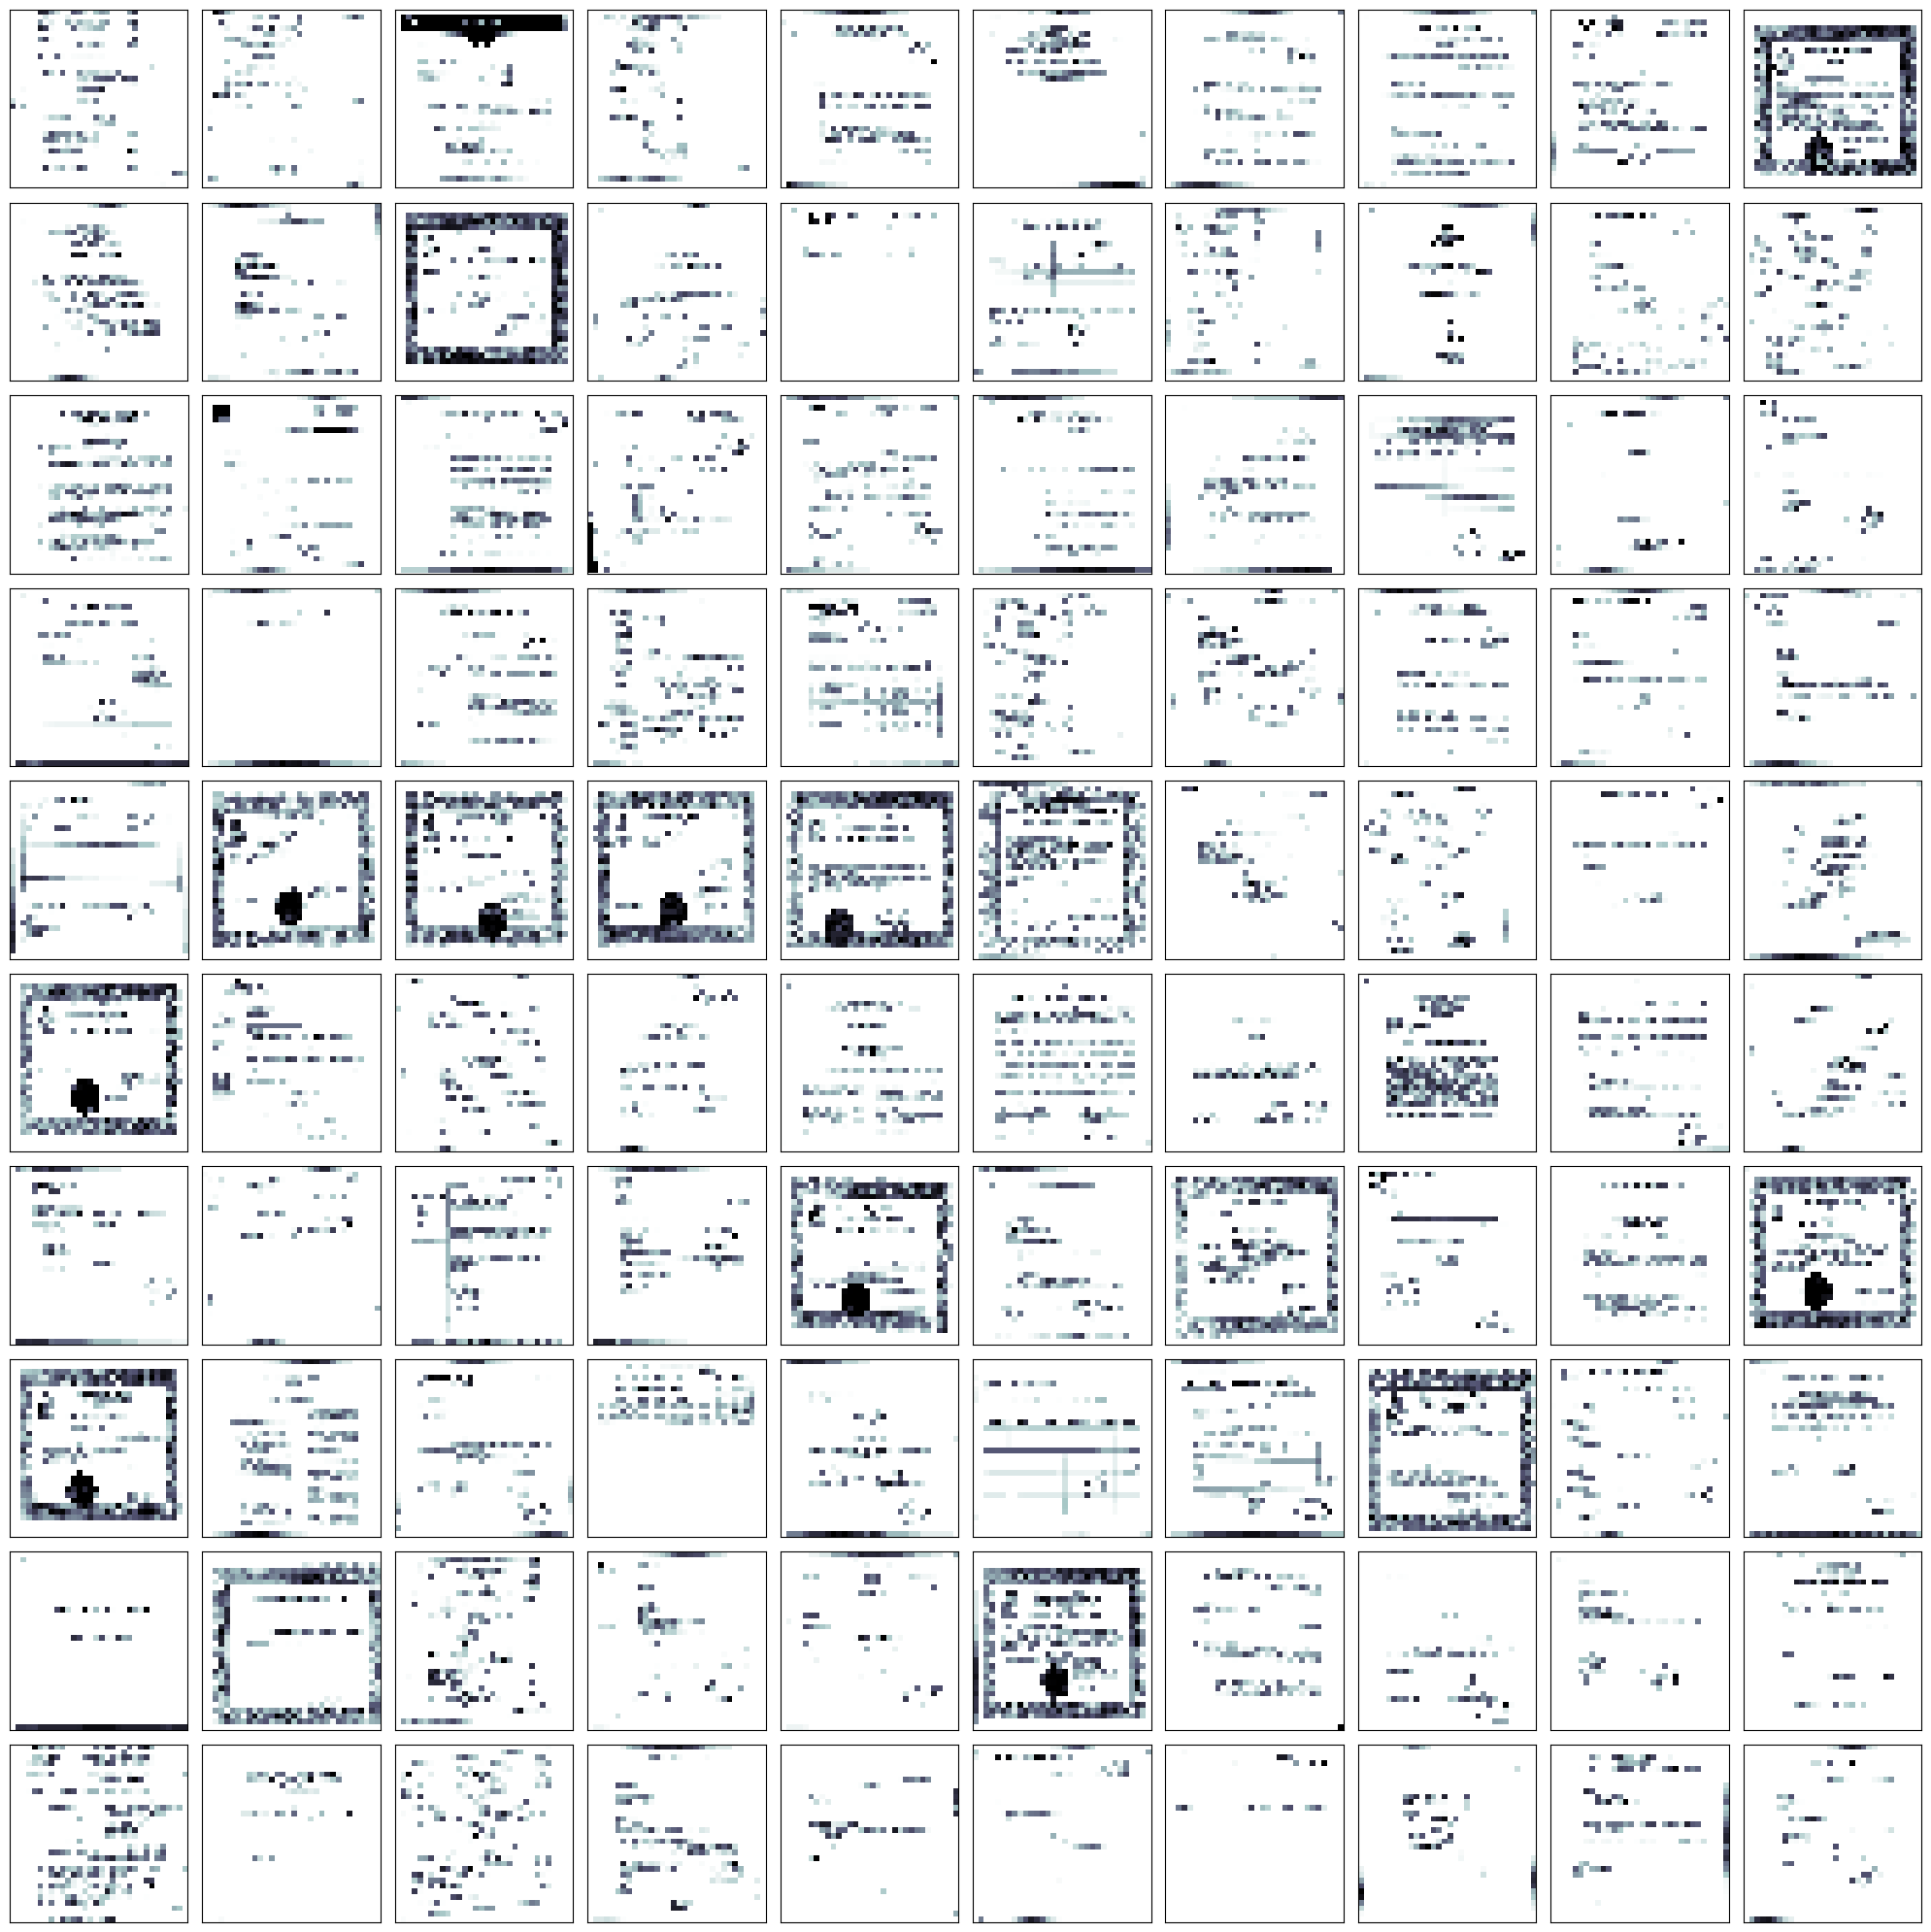

In [157]:
# display first 100 documents in a grid 
def display_all_docs():
    cols = 10
    rows = int(np.ceil(len(documents[:100])/cols))
    plt.figure(figsize=(20,rows*2))
    for i,doc in enumerate(documents[:100]):
        plt.subplot(rows, cols, 1+i)
        plt.imshow(doc.reshape(max_w,max_h), cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig('results/preprocessed_docs.pdf', format='pdf')
    plt.show()

display_all_docs()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


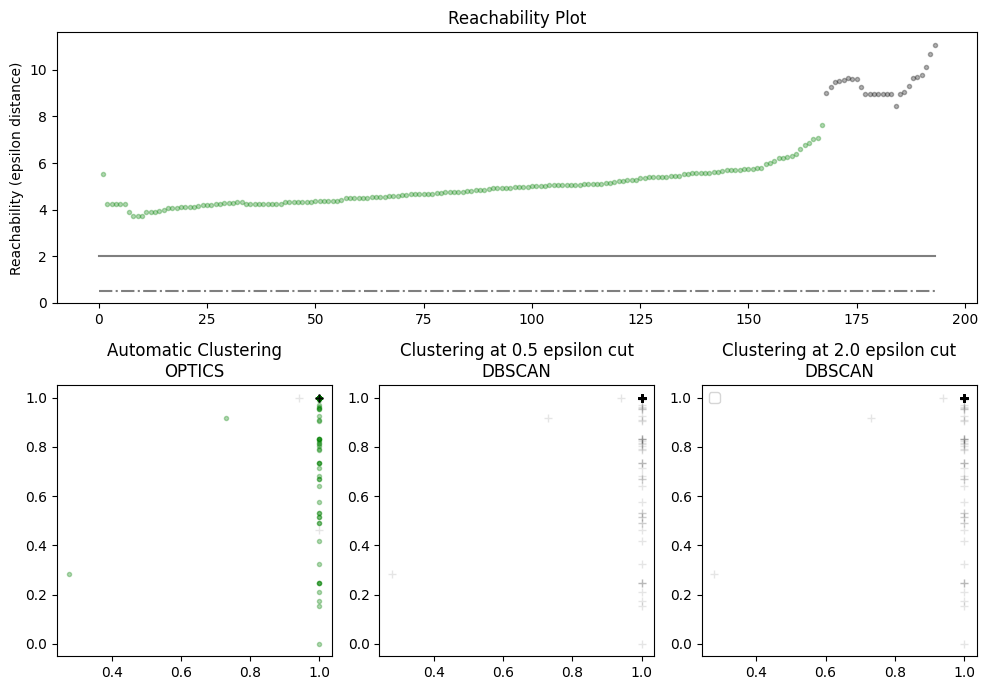

In [158]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import OPTICS, cluster_optics_dbscan


# Run the fit
clust = OPTICS(min_samples=10)
clust.fit(documents)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(documents))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3, label=(f"class {klass}" if len(Xk) > 0 else None))
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3, label="noise")
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5) # DBCAN epsilon 2
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)    # DBCAN epsilon 0.5
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")
plt.legend(loc="upper left")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = documents[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(documents[clust.labels_ == -1, 0], documents[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = documents[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(documents[labels_050 == -1, 0], documents[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = documents[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(documents[labels_200 == -1, 0], documents[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

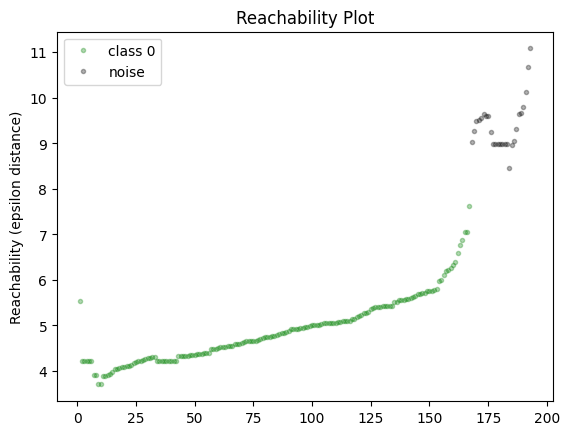

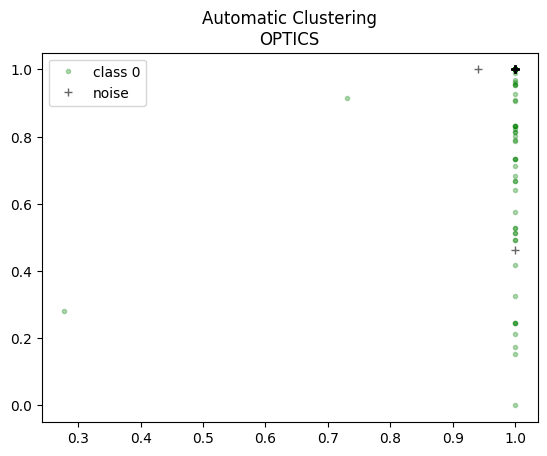

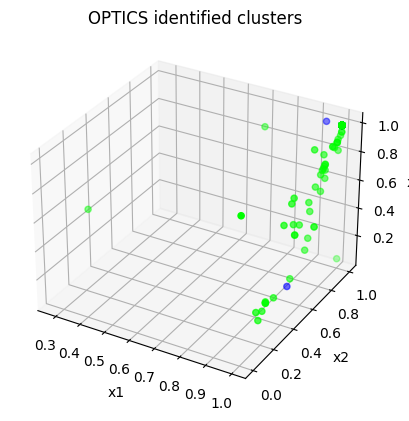

In [178]:
def get_optics_plot(documents, max_eps=np.inf, cluster_method='xi', eps=np.inf, save=False):
    if cluster_method == 'xi':
        clust = OPTICS(min_samples=10, metric='euclidean', cluster_method='xi')
    else:
        clust = OPTICS(min_samples=10, metric='euclidean', max_eps=max_eps, cluster_method='dbscan', eps=eps)
    clust.fit(documents)
    reachability = clust.reachability_[clust.ordering_]
    labels = clust.labels_[clust.ordering_]
    space = np.arange(len(documents))

    # Reachability plot
    colors = ["g.", "r.", "b.", "y.", "c."]
    for klass, color in zip(range(0, 5), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        plt.plot(Xk, Rk, color, alpha=0.3, label=(f"class {klass}" if len(Xk) > 0 else None))
    plt.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3, label="noise")
    plt.ylabel("Reachability (epsilon distance)")
    plt.title("Reachability Plot")
    plt.legend()
    if save:
        plt.savefig('results/reachability_plot.pdf', format='pdf')
    plt.show()

    # OPTICS
    colors = ["g.", "r.", "b.", "y.", "c."]
    for klass, color in zip(range(0, 5), colors):
        Xk = documents[clust.labels_ == klass]
        plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, label=(f"class {klass}" if len(Xk) > 0 else None))
    plt.plot(documents[clust.labels_ == -1, 0], documents[clust.labels_ == -1, 1], "k+", alpha=0.6, label="noise")
    plt.title("Automatic Clustering\nOPTICS")
    plt.legend()
    plt.show()


    # OPTICS 3d
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    x1 = documents[:, 0]
    x2 = documents[:, 1]
    x3 = documents[:, 2]

    ax.scatter(x1, x2, x3, marker='o', c=clust.labels_, cmap="brg")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    plt.title('OPTICS identified clusters')
    if save:
        plt.savefig('results/OPTICS_cluster.pdf', format='pdf')
    return labels

labels = get_optics_plot(documents, save=True)

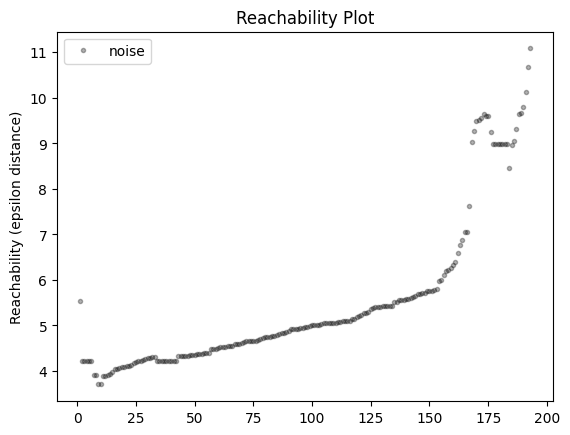

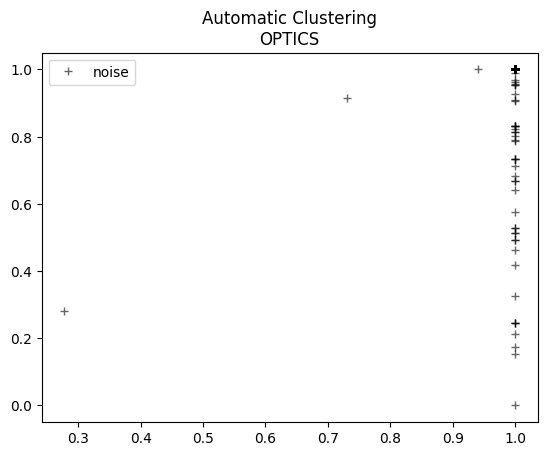

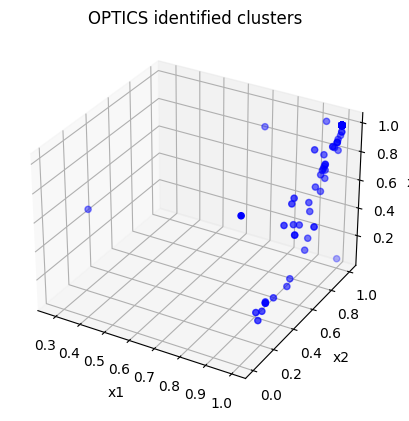

In [169]:
get_optics_plot(documents, cluster_method='dbscan')#, eps=7)

plot examples per class

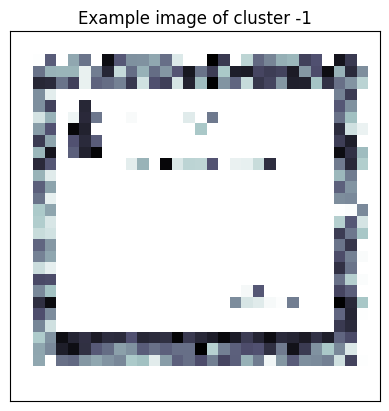

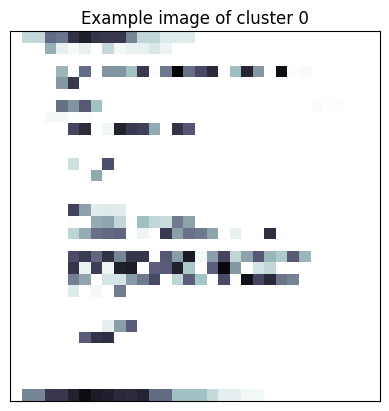

In [172]:
import random
for klass, color in zip(range(-1, 5), colors):
    cluster_instances = documents[labels == klass]
    if len(cluster_instances) == 0:
        continue
    doc = random.choice(cluster_instances)
    plt.imshow(doc.reshape(max_w,max_h), cmap=plt.cm.bone)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Example image of cluster {klass}')
    plt.savefig(f'results/example_image_cluster_{klass}.pdf', format='pdf')
    plt.show()

get 32x32 pixel images from PCA

In [173]:
from sklearn import decomposition

large_documents_raw = [(plt.imread(fp.path)) for fp in os.scandir("/Users/klara/Documents/uni/bachelorarbeit/images") if fp.path.endswith(".png")]

large_max_w = 0
large_max_h = 0
for doc in large_documents_raw:
    large_max_w = np.maximum(large_max_w, doc.shape[0])
    large_max_h = np.maximum(large_max_h, doc.shape[1])
print(large_max_w, large_max_h)

documents = []
for doc in documents_raw:
    C = np.ones((large_max_w, large_max_h))
    C[:doc.shape[0],:doc.shape[1]] = rgb2gray(doc)
    documents.append(C.ravel())
documents = np.asarray(documents)
print(documents.shape)


880 1026
(194, 902880)


In [174]:
pca = decomposition.PCA(n_components=documents.shape[0], whiten=True, svd_solver="randomized")
pca_weights = pca.fit_transform(documents)

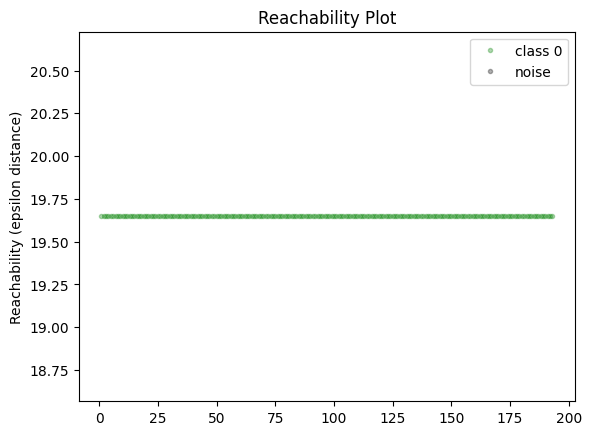

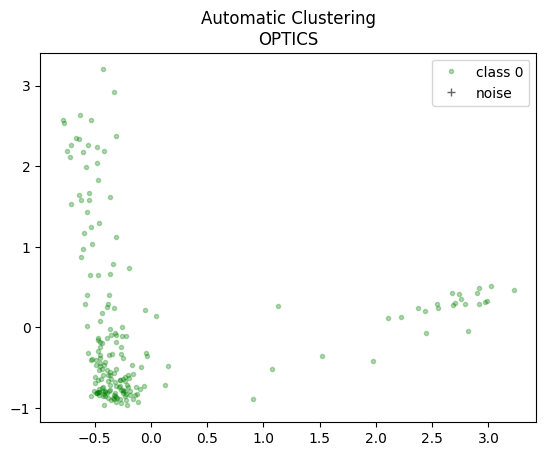

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

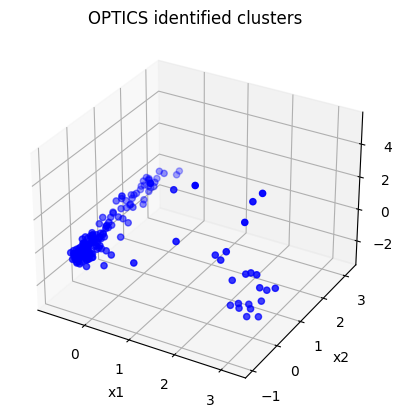

In [175]:
get_optics_plot(pca_weights, cluster_method='xi')

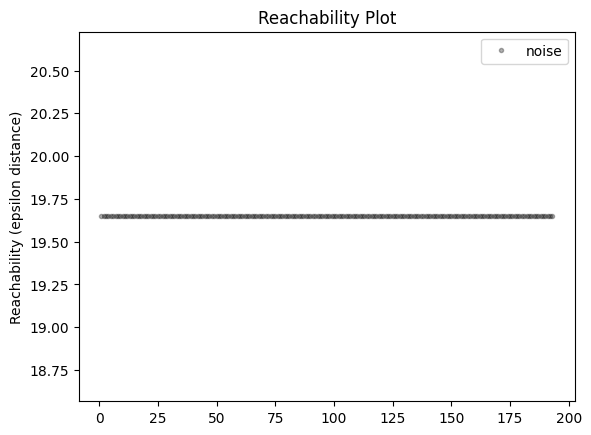

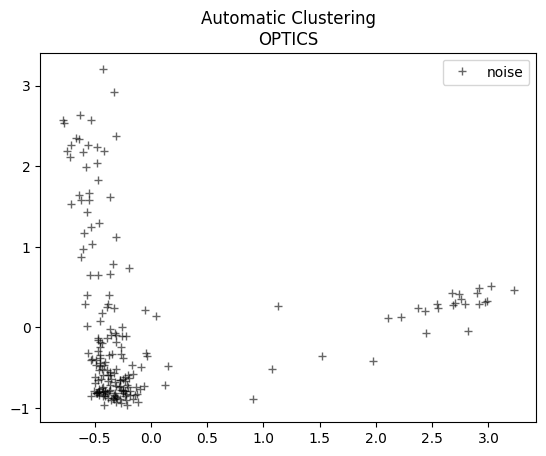

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

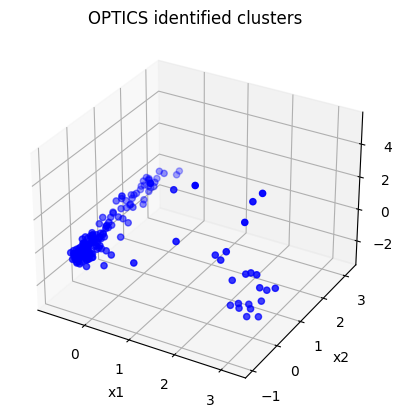

In [176]:
get_optics_plot(pca_weights, cluster_method='dbscan')